# Predator-Prey Dynamics Model


## Introduction

The following tutorial aims to describe a more dynamic model using the `ABSESpy`. It consists of an implementation of the Lotka-Volterra model which presents a simple ecosystem with two species: predators and preys. This model was originally proposed as a system of first-order, non-linear differential equations and has found its computation, individual-based simulation counterparts.

This introductory tutorial illustrates:

1. Converting a property of `PatchCell` to raster attribute.
2. Managing different breeds of `Actor` and their parameters.
3. Implement randomly actions of `Actor`.

The model aims to capture the dynamical evolution of the population of wolves and the population of sheep. It recreates a simple food chain where wolves feed on sheep and, in turn, sheep feed on grass. Both sheep and wolves have energy levels that are invariable affected by their movement. A move costs energy that can only be replenish by eating. 

## The Grass Patchcell


In [1]:
from abses import Actor, MainModel, PatchCell
from abses.cells import raster_attribute

In [35]:
class Grass(PatchCell):
    """Custom patch cell class"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.empty = False
        self._countdown = 5

    def grow(self):
        """Grow some grass on the cell every 5 ticks."""
        # countdown on brown patches: if you reach 0, grow some grass
        if self.empty is True:
            if self._countdown <= 0:
                self.empty = False
                self._countdown = 5
            else:
                self._countdown -= 1

    @raster_attribute
    def empty(self) -> bool:
        """Return True if the cell is empty, False otherwise."""
        return self._empty

    @empty.setter
    def empty(self, value: bool) -> None:
        """Set the empty status of the cell."""
        self._empty = value

## Agents Classes


In [36]:
class Animal(Actor):
    """Custom animal"""

    def __init__(self, *args, **kwargs):
        Actor.__init__(self, *args, **kwargs)
        self.energy = 5

    def update(self):
        """Update the animal's state."""
        # consume energy
        self.energy -= 1
        if self.energy <= 0:
            self.die()

    def reproduce(self):
        """Reproduce if there's enough energy."""
        if self.random.random() < self.params.rep_rate:
            self.energy /= 2
            self.at.agents.new(self.__class__)

In [37]:
class Wolf(Animal):
    """Custom wolf."""

    def step(self):
        self.move.random()
        self.eat_sheep()
        self.reproduce()
        self.update()

    def eat_sheep(self):
        """If there is a sheep in the cell, eat it and gain 2 energy."""
        sheep_here = self.at.agents.select("Sheep")
        if a_sheep := sheep_here.random.choice(when_empty="return None"):
            a_sheep.die()
            self.energy += 2


class Sheep(Animal):
    """Custom sheep."""

    def step(self):
        self.move.random()
        self.eat_grass()
        self.reproduce()
        self.update()

    def eat_grass(self):
        """If there is a grass in the cell, eat it and gain 2 energy."""
        if self.get("empty", target="world") is False:
            self.energy += 2
            self.set("empty", True, target="world")

## The Model


In [38]:
class WolfSheepModel(MainModel):
    """Wolf-Sheep predation tutorial model."""

    def setup(self):
        # initialize a grid
        grassland: PatchModule = self.nature.create_module(
            how="from_resolution",
            shape=self.params.shape,
            name="grassland",
            cell_cls=Grass,
        )
        # add sheep and wolves
        self.agents.new(Wolf, self.params.n_wolves)
        self.agents.new(Sheep, self.params.n_sheep)
        # without a specific position, agents will move randomly on the layer.
        self.agents.apply(lambda x: x.move.to(pos="random", layer=grassland))

    def step(self):
        self.nature.grassland.apply(lambda c: c.grow())
        self.check_end()

    def check_end(self):
        """Check if the model should stop."""
        # end model
        if not self.agents.has("Sheep"):
            self.running = False
        elif not self.agents.has("Wolf"):
            self.running = False
        elif self.agents.has("Sheep") >= 400:
            self.running = False

    @property
    def n_grass(self):
        """Return the number of grass patches."""
        empty = self.nature.grassland.get_raster("empty")
        return empty.size - empty.sum()

## Simulations

We are now able to run simulations. We instantiate a model to run for 100 steps. It will have a ratio of 4 sheep for every wolf. We keep the reproduction rates low. We will then plot the resulting evolution in the populations of wolves and sheep. 

In [43]:
parameters = {
    "time": {"end": 100},
    "reports": {
        "model": {
            "n_sheep": ':lambda x: x.agents.has("Sheep")',
            "n_wolves": ':lambda x: x.agents.has("Wolf")',
            "n_grass": ":lambda x: x.n_grass",
        }
    },
    "model": {
        "shape": (10, 10),
        "n_sheep": 80,
        "n_wolves": 20,
    },
    "wolf": {"rep_rate": 0.05},
    "sheep": {"rep_rate": 0.10},
}

model = WolfSheepModel(parameters=parameters)
model.run_model()

[2024-03-20 18:42:05][human          ] | Initializing a new Human Module...
[2024-03-20 18:42:05][nature         ] | Initializing a new Base Nature module...
[2024-03-20 18:42:05][main           ] | Setting up WolfSheepModel...
[2024-03-20 18:42:05][nature         ] | Initializing a new Model Layer...
[2024-03-20 18:42:05][nature         ] | Using rioxarray version: 0.13.4
[2024-03-20 18:42:05][container      ] | Created 20 actors of breed Wolf
[2024-03-20 18:42:05][container      ] | Created 80 actors of breed Sheep
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Wolf
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Wolf
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Sheep
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Sheep
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Sheep
[2024-03-20 18:42:05][container      ] | Created 1 actors of breed Sheep
[2024-03-20 18:42:05][container      ] | 

In this single run, the results show diverging populations. At first, the sheep population declines and the wolf population increases. Then, the wolf population declines and the sheep population increases. All wolves disappear and the sheep population reaches the carrying capacity of the environment.

<Axes: >

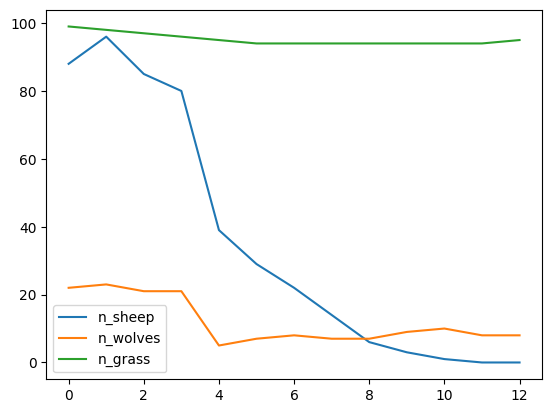

In [ ]:
model.datacollector.get_model_vars_dataframe().plot()